In [1]:
import numpy as np
import nibabel as nib
import nilearn 
import matplotlib.pyplot as plt
import os
from os.path import join as opj
import pandas as pd
import seaborn as sns
import glob
from nilearn import plotting
from nilearn.image import *
import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
from nilearn.plotting import plot_img, plot_epi
from nilearn.maskers import NiftiMasker
from sklearn.preprocessing import StandardScaler
import wandb
import pickle
from torch.utils.data import Dataset, DataLoader
from dataset import fMRI_Dataset, fMRI_Text_Dataset
import torch
from torch import nn
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint

from pytorch_lightning.loggers import WandbLogger
from network import Encoder, ContrastiveModel
import torch
import torch.nn as nn
import pytorch_lightning as pl

/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
import numpy as np
import nibabel as nib
import nilearn 
import matplotlib.pyplot as plt
import os
from os.path import join as opj
import pandas as pd
import seaborn as sns
import glob
from nilearn import plotting
from nilearn.image import *
import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
from nilearn.plotting import plot_img, plot_epi
from nilearn.maskers import NiftiMasker
from sklearn.preprocessing import StandardScaler
import wandb
import pickle
from torch.utils.data import Dataset, DataLoader
from dataset import fMRI_Dataset, fMRI_Text_Dataset
import torch
from torch import nn
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint

from pytorch_lightning.loggers import WandbLogger
from network import Encoder, ContrastiveModel
import torch
import torch.nn as nn
import pytorch_lightning as pl

/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
wandb.login()
wandb.init(project="BrainTuning",config={"model":"best_text_model"})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matteoferrante. Use `wandb login --relogin` to force relogin


In [3]:
## load the data

train_datasets=[]
val_datasets=[]
test_datasets=[]

for subj in tqdm.tqdm(["CSI1","CSI2","CSI3","CSI4"]):

    subj_id = int(subj.split("CSI")[1])

    data_path =  f"/home/matteo/storage/brain_tuning/{subj}"

    train_fmri = np.load(opj(data_path, "TEXT_train_fmri_top.npy"))
    val_fmri = np.load(opj(data_path, "TEXT_val_fmri_top.npy"))
    test_fmri = np.load(opj(data_path, "TEXT_test_fmri_top.npy"))

    ##load the captions
    train_captions = np.load(opj(data_path, "train_captions.npy"),allow_pickle=True)
    val_captions = np.load(opj(data_path, "val_captions.npy"),allow_pickle=True)
    test_captions = np.load(opj(data_path, "test_captions.npy"),allow_pickle=True)

    ## load the features
    train_features = np.load(opj(data_path, "train_text_features.npy"))
    val_features = np.load(opj(data_path, "val_text_features.npy"))
    test_features = np.load(opj(data_path, "test_text_features.npy"))

    ## create the dataset
    train_dataset = fMRI_Text_Dataset(train_fmri,train_captions,train_features,subj_id)
    val_dataset = fMRI_Text_Dataset(val_fmri,val_captions,val_features,subj_id)
    test_dataset = fMRI_Text_Dataset(test_fmri,test_captions,test_features,subj_id)

    ## append the datasets
    train_datasets.append(train_dataset)
    val_datasets.append(val_dataset)
    test_datasets.append(test_dataset)





100%|██████████| 4/4 [00:00<00:00, 11.29it/s]


In [4]:
## Concatenate the datasets
train_dataset = torch.utils.data.ConcatDataset(train_datasets)
val_dataset = torch.utils.data.ConcatDataset(val_datasets)
test_dataset = torch.utils.data.ConcatDataset(test_datasets)


In [5]:
BATCH_SIZE = 512
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
## optimal parameter obtained from the hyperparameter search

act_fn = nn.Identity
base_channel_size = [2048]
hidden_dims = [1024]
latent_dim = 512

loss_type = "contrastive"
lr = 1e-4
temperature = 0.1
wd = 1e-5
alpha = 0.8

In [13]:
brain_model = ContrastiveModel(num_input_channels= 10000,
                                base_channel_size=base_channel_size, 
                                hidden_dims=hidden_dims,
                                latent_dim=latent_dim,
                                act_fn=act_fn,
                                loss_type=loss_type,
                                lr = lr,
                                wd = wd,
                                alpha=alpha)

# Set up early stopping to monitor 'val_loss'
early_stop_callback = EarlyStopping(monitor='val_loss', patience=1,verbose=True, mode='min')             # 'min' because we want to minimize val_loss
wandb_logger = WandbLogger()  # Logs the model and metrics to wandb


# Set up early stopping to monitor 'val_loss'
early_stop_callback = EarlyStopping(monitor='val_loss', patience=1,verbose=True, mode='min')             # 'min' because we want to minimize val_loss
wandb_logger = WandbLogger()  # Logs the model and metrics to wandb


# Create a unique checkpoint directory based on the run name or ID
run_name = wandb.run.name or wandb.run.id  # Use run name if available, otherwise use run ID
checkpoint_dir = os.path.join(data_path, "models", run_name)
os.makedirs(checkpoint_dir, exist_ok=True)

# Model checkpoint configuration
checkpoint_callback = ModelCheckpoint(monitor='val_loss',dirpath=checkpoint_dir,filename='TEXT_brain_model-{epoch:02d}-{val_loss:.2f}',save_top_k=3,mode='min',)


# Initialize trainer with logger

trainer = pl.Trainer(max_epochs=20, devices=[1], callbacks=[early_stop_callback,checkpoint_callback],logger=wandb_logger ) # Add the wandb logger here

trainer.fit(brain_model, train_loader, val_loader)

/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performanc

Sanity Checking: 0it [00:00, ?it/s]

/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 255 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 512. To avoid any miscalculations, use `self.log(..., batch_size=batch_size

Training: 0it [00:00, ?it/s]

/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 317. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

/home/matteo/anaconda3/envs/braindiff/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 359. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
Metric val_loss improved. New best score: 5.491


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.208 >= min_delta = 0.0. New best score: 5.283


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.104 >= min_delta = 0.0. New best score: 5.179


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 5.116


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 5.087


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 5.074


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 5.062


Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 1 records. Best score: 5.062. Signaling Trainer to stop.


In [11]:
# train_features.shape

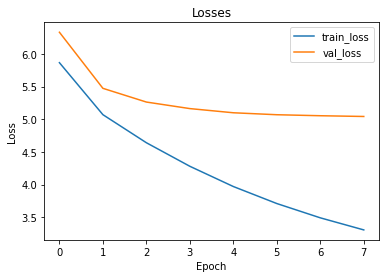

<Figure size 432x288 with 0 Axes>

In [14]:
## plot the losses
output_path = "/home/matteo/storage/brain_tuning/"

plt.plot(brain_model.train_history['train_loss'], label='train_loss')
plt.plot(brain_model.val_history['val_loss'][:-1], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')

plt.show()

## save the plot
plt.savefig(opj(output_path, "text_losses.png"))

In [18]:
from text_evaluation import *


In [19]:
results_df, similarity_matrices, results = evaluate_and_log(test_loader,brain_model)


100%|██████████| 6/6 [00:03<00:00,  1.68it/s]


Starting evaluation...
Evaluating metrics for subject 1...
Computed similarity matrix for subject 1.
Top-1 Accuracy: 0.0177, Top-5 Accuracy: 0.0735 for subject 1.
Identification accuracy for subject 1: 0.8444
Logged top-5 retrievals for subject 1.
Evaluating metrics for subject 2...
Computed similarity matrix for subject 2.
Top-1 Accuracy: 0.0114, Top-5 Accuracy: 0.0520 for subject 2.
Identification accuracy for subject 2: 0.7920
Logged top-5 retrievals for subject 2.
Evaluating metrics for subject 3...
Computed similarity matrix for subject 3.
Top-1 Accuracy: 0.0292, Top-5 Accuracy: 0.0672 for subject 3.
Identification accuracy for subject 3: 0.8115
Logged top-5 retrievals for subject 3.
Evaluating metrics for subject 4...
Computed similarity matrix for subject 4.
Top-1 Accuracy: 0.0086, Top-5 Accuracy: 0.0535 for subject 4.
Identification accuracy for subject 4: 0.7611
Logged top-5 retrievals for subject 4.
Evaluation complete. Results loaded to wandb.


In [20]:
results_df.to_csv(opj(output_path,"results_text_contrastive.csv"))

In [22]:
def get_good_example_indices(similarity_matrix, gt_texts, num_examples=10):
    """
    Get indices of good examples where the retrieved images include the stimulus image in the top-5.
    
    Args:
        similarity_matrix (np.array): Cosine similarity matrix between predicted and ground truth embeddings.
        gt_texts (list): List of ground truth texts.
        num_examples (int): Number of good examples to retrieve.

    Returns:
        List of tuples: Each tuple contains (stimulus_index, top5_indices), where:
                        - stimulus_index is the index of the stimulus image.
                        - top5_indices are the indices of the top-5 retrieved images.
    """
    # Identify indices where the correct image is among the top-5 retrieved
    good_examples_indices = [
        i for i in range(len(gt_texts)) if i in np.argsort(-similarity_matrix[i])[:5]
    ]
    
    # Randomly select up to `num_examples` from good examples
    if len(good_examples_indices) > num_examples:
        good_examples_indices = np.random.choice(good_examples_indices, num_examples, replace=False)
    
    # Gather (stimulus_index, top5_indices) for each good example
    example_indices = []
    for i in good_examples_indices:
        sim_scores = similarity_matrix[i]
        top5_indices = np.argsort(-sim_scores)[:5]
        example_indices.append((i, top5_indices.tolist()))

    return example_indices

good_example_indices = get_good_example_indices(similarity_matrices[1], results[1]["gt_texts"])
good_example_indices  # [(stimulus_index, [top5_index1, top5_index2, ..., top5_index5]), ...]


[(299, [488, 299, 408, 380, 734]),
 (761, [616, 558, 453, 24, 761]),
 (524, [179, 524, 657, 165, 712]),
 (12, [110, 420, 622, 129, 12]),
 (100, [33, 720, 780, 240, 100]),
 (305, [523, 763, 296, 289, 305]),
 (456, [316, 355, 87, 777, 456]),
 (585, [585, 195, 420, 343, 350]),
 (448, [448, 417, 298, 28, 113]),
 (539, [498, 500, 539, 686, 286])]

In [31]:
def get_random_example_indices(similarity_matrix, gt_texts, num_examples=10):
    """
    Get random indices to visualize general performance of the model, with the top-5 retrieved images.
    
    Args:
        similarity_matrix (np.array): Cosine similarity matrix between predicted and ground truth embeddings.
        gt_texts (list): List of ground truth images.
        num_examples (int): Number of random examples to retrieve.

    Returns:
        List of tuples: Each tuple contains (stimulus_index, top5_indices), where:
                        - stimulus_index is the index of the stimulus image.
                        - top5_indices are the indices of the top-5 retrieved images.
    """
    # Select random indices for visualization
    random_indices = np.random.choice(range(len(gt_texts)), num_examples, replace=False)
    
    # Gather (stimulus_index, top5_indices) for each random example
    example_indices = []
    for i in random_indices:
        sim_scores = similarity_matrix[i]
        top5_indices = np.argsort(-sim_scores)[:5]
        example_indices.append((i, top5_indices.tolist()))

    return example_indices

random_example_indices = get_random_example_indices(similarity_matrices[1], results[1]["gt_texts"])


/tmp/ipykernel_2025017/275108448.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.5)


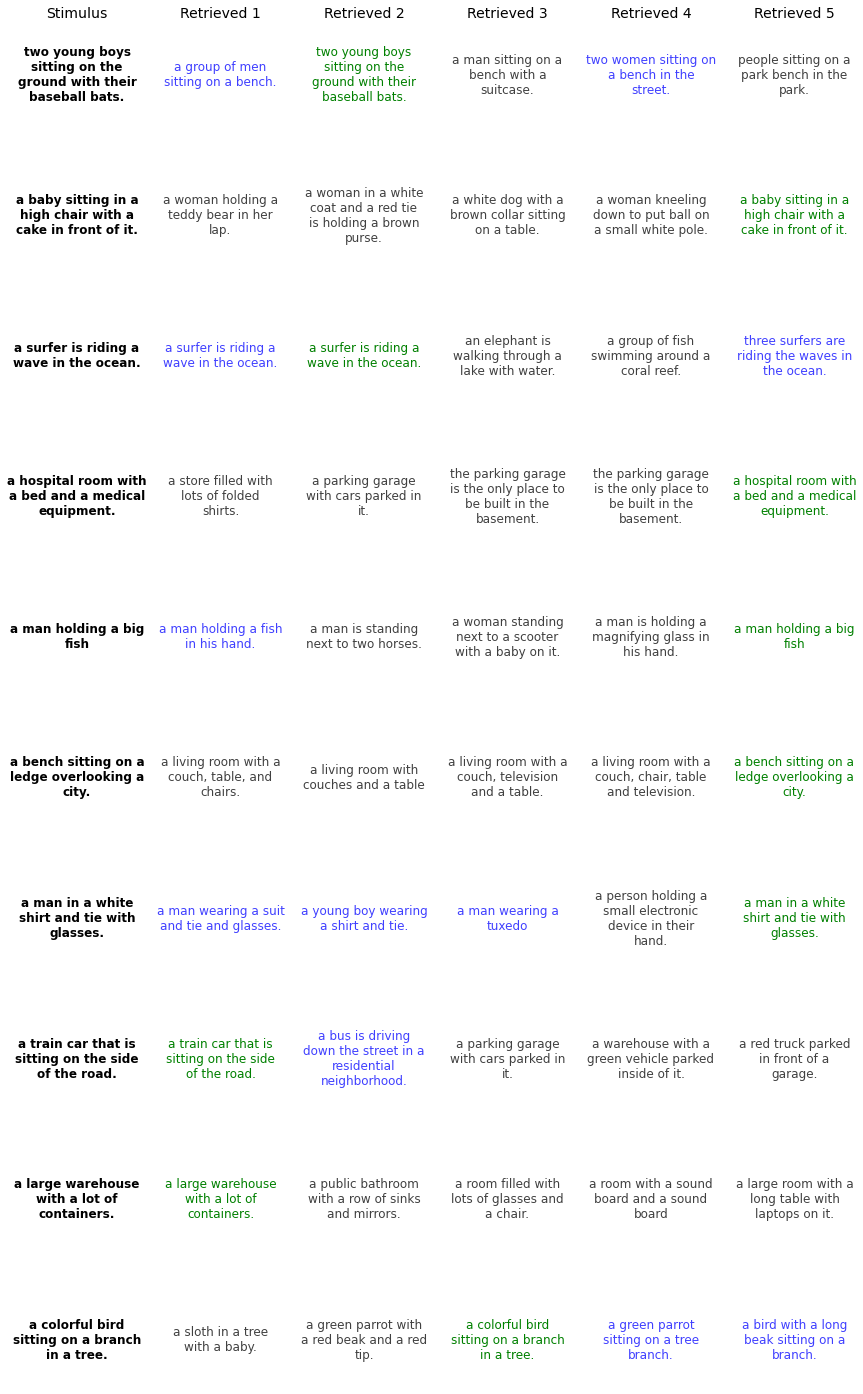

In [37]:
import matplotlib.pyplot as plt
import textwrap
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def plot_text_examples(gt_texts, example_indices, output_name="examples.png", alpha=0.75, line_width=20, similarity_matrix=None, similarity_threshold=0.6):
    """
    Plot the stimulus and top-5 retrieved captions for each good example, highlighting similar captions.

    Args:
        gt_texts (list): List of ground truth captions (text strings).
        example_indices (list): List of tuples with (stimulus_index, top5_indices) for good examples.
        output_name (str): File name to save the plot.
        alpha (float): Opacity for non-exact retrieved captions.
        line_width (int): Maximum number of characters per line for wrapping.
        similarity_matrix (np.array): Precomputed similarity matrix for captions.
        similarity_threshold (float): Threshold above which captions are considered similar and colored blue.
    """
    num_examples = len(example_indices)
    fig, axes = plt.subplots(num_examples, 6, figsize=(15, 2.5 * num_examples), facecolor="white", 
                             gridspec_kw={'wspace': 0.2, 'hspace': 0.5})
    
    for i, (stimulus_index, top5_indices) in enumerate(example_indices):
        # Plot the stimulus caption in bold
        wrapped_stimulus_text = "\n".join(textwrap.wrap(gt_texts[stimulus_index], line_width))
        axes[i, 0].text(0.5, 0.5, wrapped_stimulus_text, ha='center', va='center', wrap=True, 
                        fontsize=12, color="black", fontweight="bold")
        axes[0, 0].set_title("Stimulus", fontsize=14, pad=10)
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        axes[i, 0].set_aspect('equal')  # Make the subplot square
        axes[i,0].axis('off')

        # Plot the retrieved captions with color based on similarity
        for j, top5_idx in enumerate(top5_indices):
            wrapped_retrieved_text = "\n".join(textwrap.wrap(gt_texts[top5_idx], line_width))
            
            # Determine color based on similarity
            if similarity_matrix is not None:
                similarity_score = similarity_matrix[stimulus_index, top5_idx]
                if top5_idx == stimulus_index:
                    text_color = "green"  # Exact match
                elif similarity_score >= similarity_threshold:
                    text_color = "blue"  # Close match based on threshold
                else:
                    text_color = "black"  # Not similar enough
            else:
                text_color = "black"

            # Display text with color and opacity
            axes[i, j + 1].text(0.5, 0.5, wrapped_retrieved_text, ha='center', va='center', wrap=True,
                                fontsize=12, color=text_color, alpha=alpha if top5_idx != stimulus_index else 1)
            axes[0, j + 1].set_title(f"Retrieved {j + 1}", fontsize=14, pad=10)

            # Make each subplot square and remove ticks
            axes[i, j + 1].set_xticks([])
            axes[i, j + 1].set_yticks([])
            axes[i, j + 1].set_aspect('equal')
            axes[i,j+1].axis('off')

    plt.tight_layout(pad=0.5)
    plt.savefig(output_name)
    plt.show()

similarity_matrix = cosine_similarity(results[1]["y_gt"])  
plot_text_examples(results[1]["gt_texts"], good_example_indices, output_name=opj(output_path, "good_examples.png"), similarity_matrix=similarity_matrix)


/tmp/ipykernel_2025017/275108448.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.5)


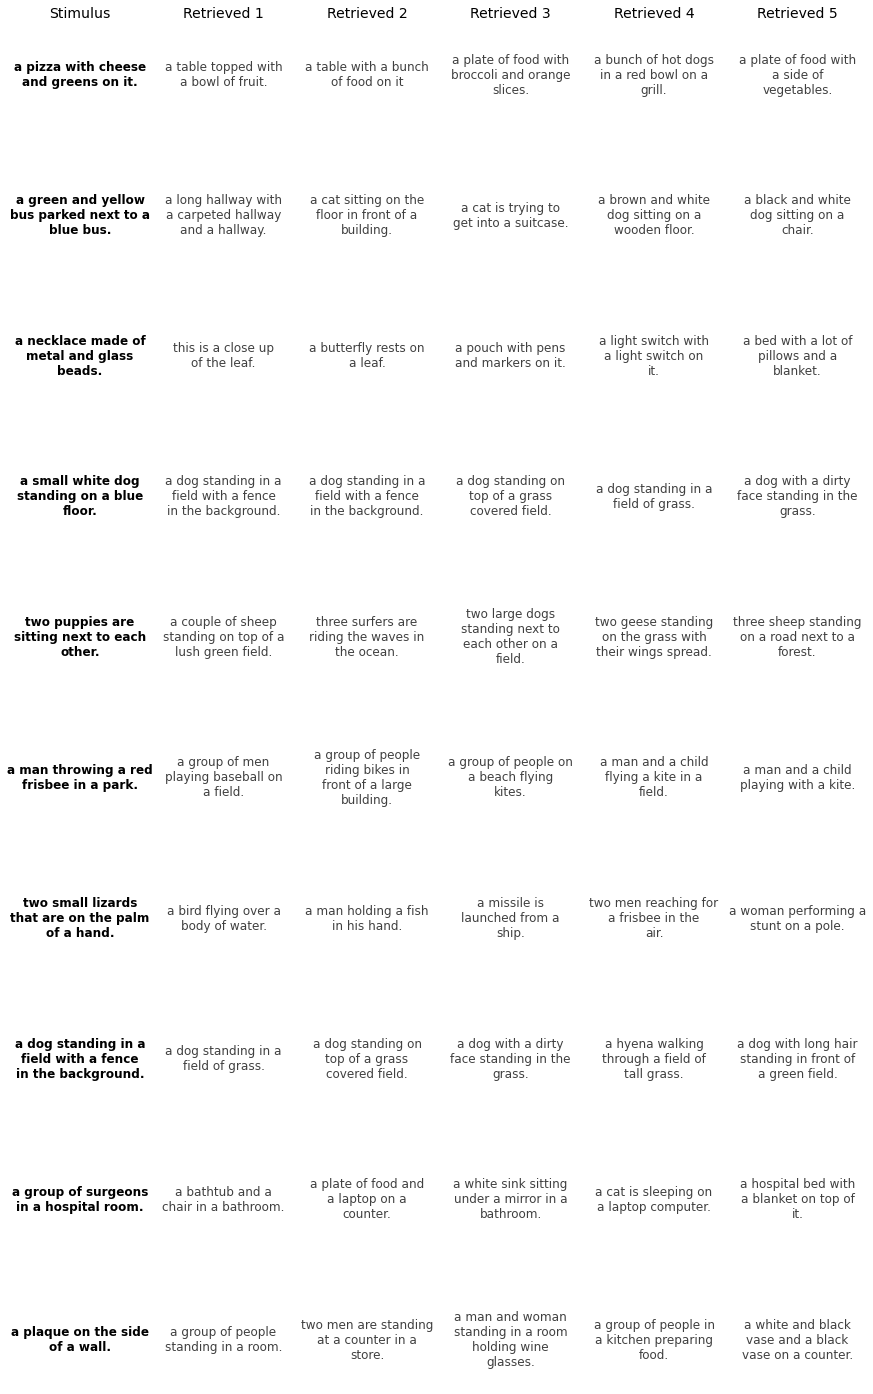

In [43]:
plot_text_examples(results[1]["gt_texts"], random_example_indices, output_name=opj(output_path, "random_text_examples.png"))
